# Guided Example for Using the Porous Media Heat Transfer Library

This notebook contains a cell-by-cell example of how to use the basics of this library. Values chosen do not necessarily have any real association and are just numbers chosen to facilitate an example. When using this library, make sure that all of your properties, dimensions, and conditions are physically accurate and consistent with your physical setup and the materials involved in your system.

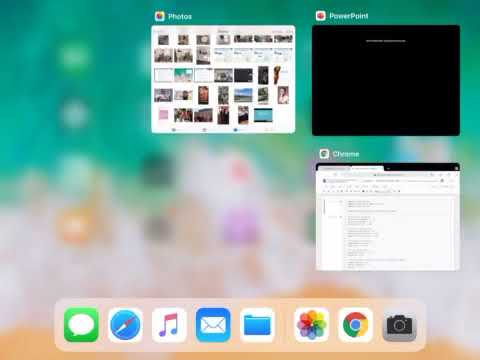

In [1]:
# Watch this video if you want to get a little background information into the theory and motivation behind this project!

from IPython.display import YouTubeVideo
YouTubeVideo('asnO85gfLm8',width=640,height=360)

In [2]:
# Import modules that you'll need to use the software and view the results.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Import the software itself.
import porous_material_convection.porous_material_convection as pmc

In [3]:
# THIS CELL HANDLES THE PHYSICAL GEOMETRY OF THE SYSTEM.

# Define the geometry of the cylindrical particles within your packed bed in millimeters. Note that if you want to use a 
# different porous material geometry, you'll have to go into the pellet_geometry_factors function and change the geometry
# equations.

particle_diameter = 3.5
particle_height = 2.5

#Define the bulk porosity of the system.
bulk_porosity = 0.38

# Calculate the hydraulic diameter needed for fluid velocity calculations and the accesible surface area per 
# unit volume of the bed needed for heat transfer calculations.
hyd_dia, surf_area = pmc.pellet_geometry_factors(particle_diameter,particle_height,bulk_porosity)

AttributeError: module 'porous_material_convection' has no attribute 'pellet_geometry_factors'

In [ ]:
# THIS CELL HANDLES THE PROPERTIES OF THE FLUID FLOWING THROUGH THE BED AND CALCULATES THE MEAN FLUID VELOCITY.

# NOTE: this function is designed to calculate properties of air, but can be modified or replaced to calculate the needed
# fluid properties for a different gas or liqud if desired.

# Define the inlet conditions of your air, i.e., temperature and pressure. Temperature is in °C and pressure is a 
# percentage of absolute. For example, if you have an inlet pressure of 3 bar, then enter 3.
Temperature_inlet = 25
Pressure_inlet = 1.25

# Calculate the density and viscosity of the air.
density, viscosity = pmc.air_properties(Temperature_inlet, Pressure_inlet)


# Define the Reynolds number you want in your system. This parameter contains information about the flow conditions and 
# is used here to calculate the mean velocity needed for the thermal field solver.

Reynolds = 50

# Calculate the mean velocity.
Vel = pmc.mean_velocity(Reynolds, density, viscosity, hyd_dia)

In [ ]:
# THIS CELL CREATES THE SYSTEM OF EQUATIONS TO BE SOLVED TO CALCULATE THE STEADY-STATE THERMAL FIELDS.

# Define the dimensions of your system. The current code is configured for a cylindrical annulus geometry, but 
# this can be easily changed within the "global_coefficient_matrix_assembly" function to use the code for different
# packed bed geometries. Bed dimensions must be entered in meters.

inner_radius = 0.1
outer_radius = 0.25
length = 0.25

# Define the grid mesh for your solver. The solver is set up for a square mesh (equal number of nodes in each direction),
# but this can easily be changed as well in the "global_coefficient_matrix_assembly" function.

nodes = 11

# Define the thermal properties of your packed bed and the fluid flowing through it. Thermal conductivity must be in 
# W/mK, and specific heat must be in J/kgK.
thermal_cond_solid = 12
thermal_cond_fluid = 0.027
specific_heat_fluid = 1006

# Define the boundary conditions for your setup. Note that the software is configured for the application of a constant 
# heat flux at the inner surface and an insulated outer surface. However, this can be changed by replacing the appropriate
# boundary condition loops and indexing structure within the "global_coefficient_matrix_assembly" function if you wish to 
# use different boundary conditions for your system.

#Heat flux, must be in W/m^2
heat_flux = 25000

# Define the heat transfer coefficient for your system. THIS IS WHERE THE SOFTWARE BECOMES MORE USER-FLEXIBLE.
# The base purpose of this software is to calculate the thermal fields for a two-phase (solid and liquid) porous material. 
# This requires information on the internal surface area (interstitial) heat transfer coefficient (HTC). For the purposes 
# of this example, a correlation from the literature is used. However, in real life, this is where a short optimization 
# program could be written to solve for a true HTC from measured temperature field data. If desired to do so, at this 
# point, remove the correlation and begin your optimization with an initial guess of the HTC. Alternatively, if you 
# already have a trustworthy correlation for your HTC, implement that here.

heat_transfer_coefficient = (thermal_cond_fluid/hyd_dia)*(2+1.1*(6*(1-bulk_porosity))**0.6*Reynolds**0.6*(specific_heat_fluid*viscosity/thermal_cond_fluid)**(1/3))

# Use all of the above inputs to create your system of equations to solve.
Coefficient_matrix, Source_vector = pmc.assemble_linear_system(inner_radius,outer_radius,length,nodes,bulk_porosity,density,Vel,thermal_cond_solid,thermal_cond_fluid,specific_heat_fluid,heat_flux,Temperature_inlet,heat_transfer_coefficient,surf_area)

In [ ]:
surf_area

In [ ]:
# THIS CELL SOLVES THE LINEAR SYSTEM AND EXTRACTS THE TEMPERATURE FIELDS FOR YOU TO VISUALIZE.

# Solve the system using your created matrices from the previous cell.
Global_temperature = pmc.solve_linear_system(Coefficient_matrix, Source_vector)

# Extract the separate steady-state thermal fields for the solid phase and fluid phase.
Solid_temperature_field, Fluid_temperature_field = pmc.extract_temperature_fields(Global_temperature,nodes)

In [ ]:
# THIS CELL PRINTS FILLED CONTOUR PLOTS OF THE STEADY-STATE THERMAL FIELDS
# SO THAT YOU CAN SEE WHAT YOUR RESULTS SHOULD LOOK LIKE.

# Create 2D physical domain space vectors for plotting.
R = np.linspace(outer_radius,inner_radius,nodes)
Z = np.linspace(0,length,nodes)

# Create the coordinate grid and plot the temperature fields in a single subplot figure.
Grid_R, Grid_Z = np.meshgrid(R,Z)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,6))

# Set labels for the first subplot and add a colorbar.
solid_temp = ax1.contourf(Grid_Z,Grid_R, Solid_temperature_field)
ax1.set_title('Temperature Field in the Solid Phase')
ax1.set_xlabel('Length of Bed (m)')
ax1.set_ylabel('Radius of Bed (m)')
plt.colorbar(solid_temp,ax = ax1)

# Set labels for the second subplot and add a colorbar.
fluid_temp = ax2.contourf(Grid_Z,Grid_R, Fluid_temperature_field)
ax2.set_title('Temperature Field in the Fluid Phase')
ax2.set_xlabel('Length of Bed (m)')
ax2.set_ylabel('Radius of Bed (m)')
plt.colorbar(fluid_temp,ax = ax2)

# Modify the layout of the subplot to make for nicer viewing.
fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=None)

You now have two arrays of temperature data, one for the solid portion of your porous material and one for the fluid flowing within the porous material. You can now use this data for whatever you might want. Here are a few examples:

1. Sizing a new porous material system to get a desired temperature effect.
2. Understanding how using different materials will allow for control of the thermal behavior by varying properties.
3. Figuring out what flow rates the fluid should be to create a desired thermal effect.
4. How much power needs to be entering the system to maintain a steady thermal effect.
5. Changing the geometric parameters (either in this example or within the functions themselves) to look at how different geometries can change your thermal fields.

Enjoy!